In [40]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [41]:
X = df.drop(columns=['BMI']).values #입력 데이터
Y = df['BMI'].values #예측할 변수

X.shape, Y.shape

((768, 8), (768,))

In [42]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
class ImprovedRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128) # 입력8 연결층
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.3) #과적합 예방 + 일반화 성능 up - 30% 확률로 뉴런 종

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # 8개 특성 -> 128개로 늘림 음수->0, 양수 그대로
        x = self.dropout(x) # 랜덤으로 뉴런 종료
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x) # 예측한 BMI 한개 출력
        return x


In [47]:
#학습 엔진 (adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad() #기울기 초기화
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y) #loss 계산
        loss.backward()
        optimizer.step() # 가중치 수정
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 30.6696
Epoch 2/100, Loss: 31.0280
Epoch 3/100, Loss: 30.9917
Epoch 4/100, Loss: 31.2049
Epoch 5/100, Loss: 36.4246
Epoch 6/100, Loss: 30.2935
Epoch 7/100, Loss: 30.3587
Epoch 8/100, Loss: 30.9364
Epoch 9/100, Loss: 29.6566
Epoch 10/100, Loss: 31.1321
Epoch 11/100, Loss: 30.1527
Epoch 12/100, Loss: 29.6633
Epoch 13/100, Loss: 29.7689
Epoch 14/100, Loss: 30.2220
Epoch 15/100, Loss: 30.4665
Epoch 16/100, Loss: 30.2934
Epoch 17/100, Loss: 30.1838
Epoch 18/100, Loss: 30.8794
Epoch 19/100, Loss: 34.7137
Epoch 20/100, Loss: 30.9417
Epoch 21/100, Loss: 32.1309
Epoch 22/100, Loss: 30.1076
Epoch 23/100, Loss: 30.1698
Epoch 24/100, Loss: 30.3975
Epoch 25/100, Loss: 30.2885
Epoch 26/100, Loss: 30.7807
Epoch 27/100, Loss: 30.2757
Epoch 28/100, Loss: 31.7021
Epoch 29/100, Loss: 30.0854
Epoch 30/100, Loss: 30.6383
Epoch 31/100, Loss: 29.9538
Epoch 32/100, Loss: 30.6568
Epoch 33/100, Loss: 30.0179
Epoch 34/100, Loss: 29.9302
Epoch 35/100, Loss: 31.6188
Epoch 36/100, Loss: 32.7276
E


 test MSE: 60.9469


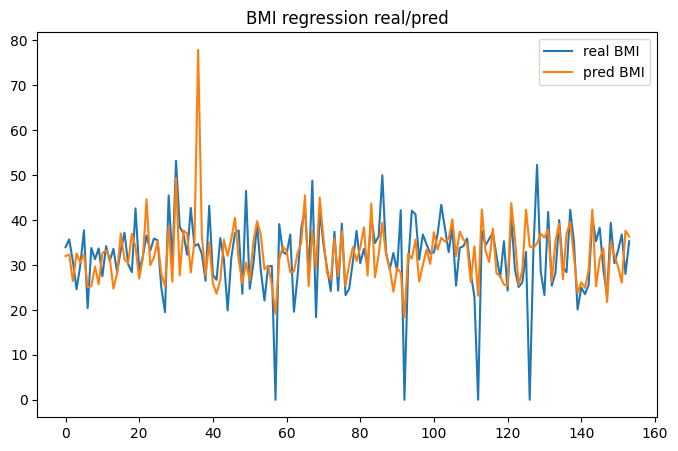

In [50]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(y_pred, Y_test).item()

print(f"\n test MSE: {mse:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(Y_test.numpy(), label='real BMI')
plt.plot(y_pred.numpy(), label='pred BMI')
plt.legend()
plt.title("BMI regression real/pred")
plt.show()